In [1]:
%pip install prophet matplotlib pandas scikit-learn seaborn



Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data handling
import pandas as pd
import matplotlib.pyplot as plt

# Forecasting
from prophet import Prophet

# Warnings
import warnings
warnings.filterwarnings('ignore')

import os
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)


In [3]:
# Load the cleaned dataset
data_path = r"C:\Users\choma\OneDrive\Documents\Profile Projects\retail-sales-analysis\data\processed\cleaned_retail_sales.csv"
df = pd.read_csv(data_path)

# Ensure proper date format
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [4]:
# Group by month and sum total sales
monthly_sales = df.set_index('date').resample('M')['total_amount'].sum().reset_index()

# Rename columns for Prophet
monthly_sales.columns = ['ds', 'y']

monthly_sales.head()


,ds,y
0,2023-01-31,35450
1,2023-02-28,44060
2,2023-03-31,28990
3,2023-04-30,33870
4,2023-05-31,53150


In [5]:
# Initialize the model
model = Prophet()
model.fit(monthly_sales)


14:08:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:41 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Forecast 12 months into the future
future = model.make_future_dataframe(periods=12, freq='M')

# Predict
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
20,2024-09-30,20003.092092,5295.723888,34593.899616
21,2024-10-31,18905.666912,4817.165033,33713.089468
22,2024-11-30,17843.642545,2863.432761,33866.923029
23,2024-12-31,16746.217365,2398.352099,30799.080480
24,2025-01-31,15648.792186,999.841239,30106.414055


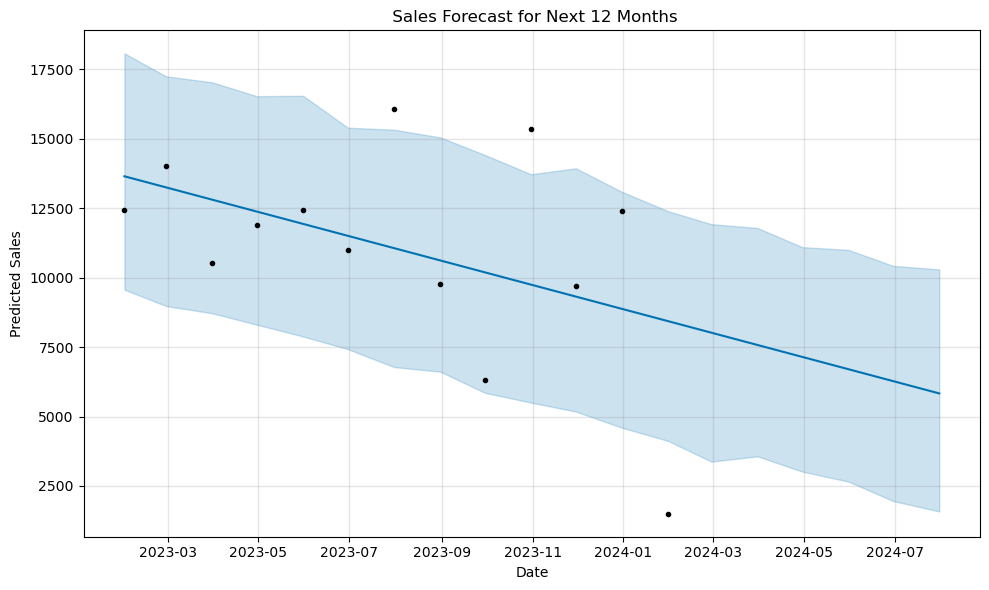

In [14]:
# Forecast plot
fig1 = model.plot(forecast)
plt.title(' Sales Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "04_sales_forecast_for_next_12_months.png"))
plt.show()


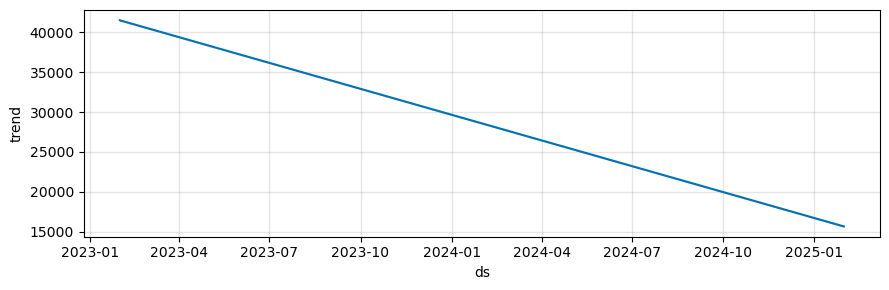

In [10]:
# Trend and seasonality
fig2 = model.plot_components(forecast)

plt.savefig(os.path.join(fig_dir, "04_trend_and_seasonality.png"))
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train-test split (last 6 months for testing)
train = monthly_sales.iloc[:-6]
test = monthly_sales.iloc[-6:]

# Fit model on train
model = Prophet()
model.fit(train)

# Make predictions for test period
future_test = model.make_future_dataframe(periods=6, freq='M')
forecast_test = model.predict(future_test)

# Compare actual vs. predicted
predicted = forecast_test.iloc[-6:]['yhat'].values
actual = test['y'].values

# RMSE
rmse = sqrt(mean_squared_error(actual, predicted))
print(f"📉 RMSE on test set: {rmse:.2f}")


14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing


📉 RMSE on test set: 17994.04



 Forecasting for category: Clothing


14:12:49 - cmdstanpy - INFO - Chain [1] start processing
14:12:50 - cmdstanpy - INFO - Chain [1] done processing


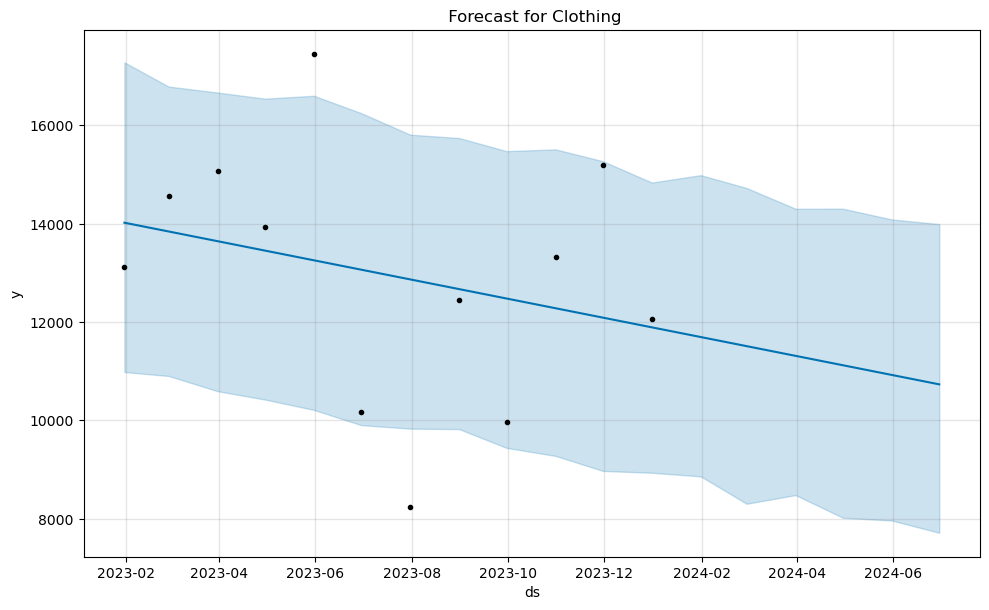


 Forecasting for category: Electronics


14:12:53 - cmdstanpy - INFO - Chain [1] start processing
14:12:53 - cmdstanpy - INFO - Chain [1] done processing


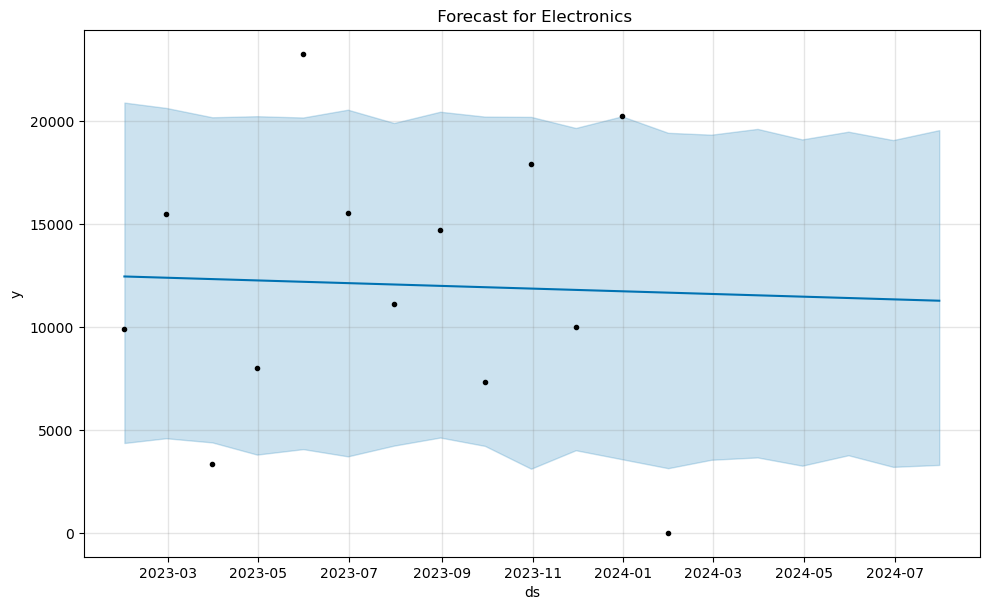


 Forecasting for category: Beauty


14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:56 - cmdstanpy - INFO - Chain [1] done processing


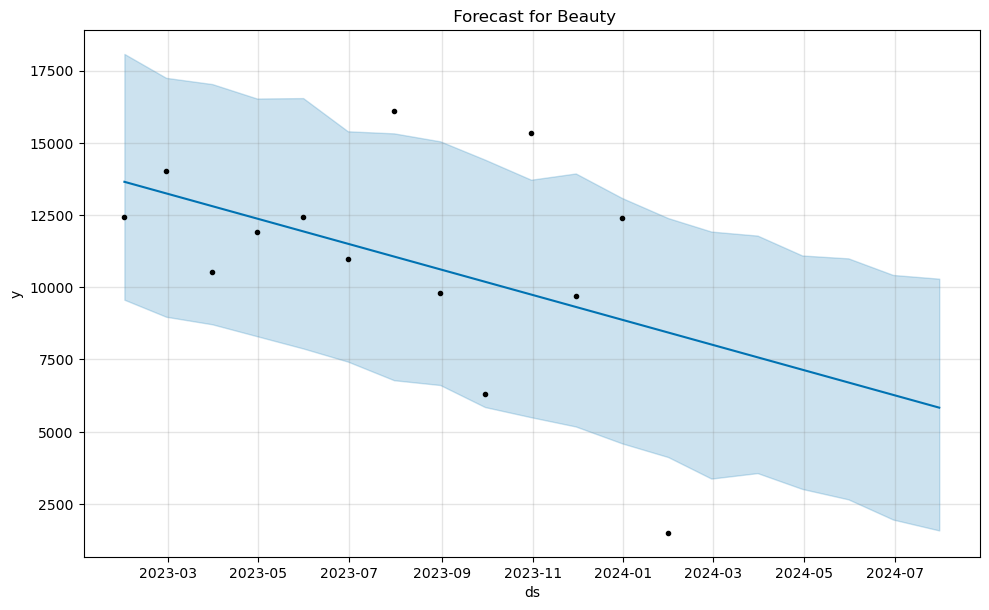

In [13]:
from prophet import Prophet

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Loop through top categories (limit to top 3–5 to avoid overkill)
top_categories = df['product_category'].value_counts().head(3).index

for category in top_categories:
    print(f"\n Forecasting for category: {category}")
    
    # Filter data
    category_df = df[df['product_category'] == category]
    
    # Monthly aggregation
    monthly_sales = category_df.set_index('date').resample('M')['total_amount'].sum().reset_index()
    monthly_sales.columns = ['ds', 'y']

    if len(monthly_sales) < 12:
        print(f" Skipping {category} (not enough data)")
        continue

    # Model and Forecast
    model = Prophet()
    model.fit(monthly_sales)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    # Plot
    model.plot(forecast)
    plt.title(f" Forecast for {category}")
    plt.savefig(os.path.join(fig_dir, "04_forecast_for_clothing.png"))
    plt.show()


14:14:53 - cmdstanpy - INFO - Chain [1] start processing
14:14:53 - cmdstanpy - INFO - Chain [1] done processing


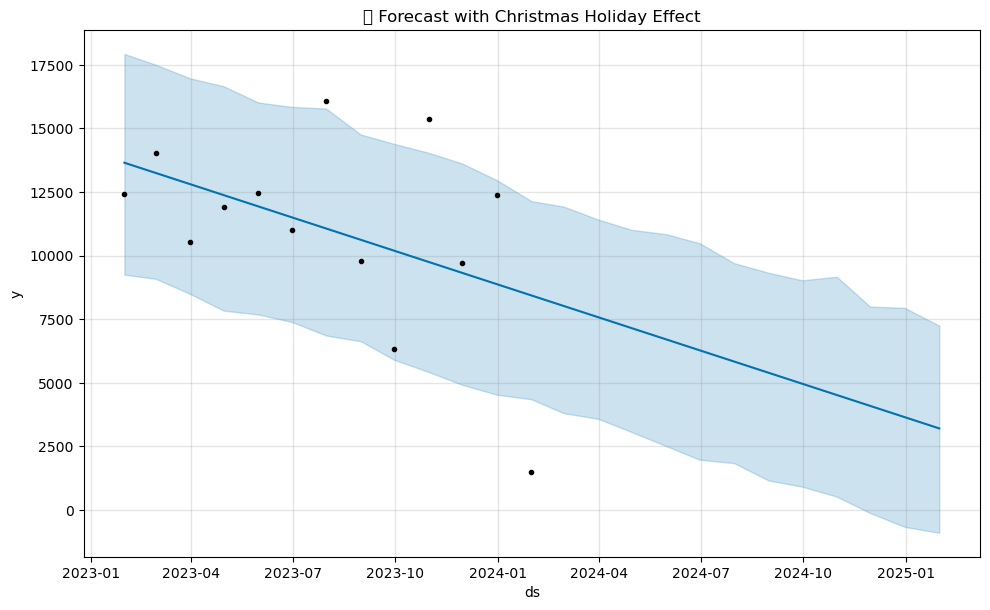

In [15]:
from prophet.make_holidays import make_holidays_df

# Define holidays manually or use built-in country holidays
from prophet.serialize import model_to_json
from prophet import Prophet

model = Prophet()

# Example: Add custom holidays
holidays = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2022-12-25', '2023-12-25', '2024-12-25']),
    'lower_window': 0,
    'upper_window': 1,
})

# Add to Prophet
model = Prophet(holidays=holidays)
model.fit(monthly_sales)

# Predict
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
model.plot(forecast)
plt.title('🎄 Forecast with Christmas Holiday Effect')

plt.savefig(os.path.join(fig_dir, "04_forecast_with_xmas_holiday_effect.png"))
plt.show()
